In [1]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import pickle
import math
import glob
import re
import contextlib
import itertools
import collections
from collections.abc import Mapping
import numpy as np
from numpy import random
import pandas as pd
import tqdm
import torch 
from transformers import AutoModelForSequenceClassification, DefaultDataCollator
from datasets import Dataset
from sklearn import linear_model
import sklearn
from sklearn import pipeline
import scipy
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import plotnine as p9
import seaborn as sns

import pyranges as pr

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score

# Code

## Roc

In [2]:
def get_roc(df, 
            score_col, 
            model, 
            label_col="original", 
            label_pos=None):
    #print(model)
    df = df.query('model == @model')
    scores = np.array(df[score_col])
    if not label_pos:
        labels=np.array(df[label_col])#.astype('int')
    else:
        labels=np.array(df[label_col] == label_pos)
    #print(len(labels), len(df))
    fpr, tpr, thresholds = roc_curve(labels, scores)
    #print(len(fpr))
    prec, rec, thresholds = precision_recall_curve(labels, scores)
    roc_auc = roc_auc_score(labels, scores)
    auc_var = delong_roc_variance(ground_truth=labels.astype('int'), 
                                   predictions = scores)[1]
    auprc = average_precision_score(labels, scores)
    return fpr, tpr, prec, rec, roc_auc, auprc, auc_var

## Loading and processing of matrices

In [3]:
def process_prbs(idx_in_file, nucprobs, one_hots, renormalize, eps=0.0001):
    if renormalize:
        nucprobs = nucprobs + eps
        nucprobs = nucprobs/nucprobs.sum(axis=-1,keepdim=True)
    nucprobs = nucprobs[idx_in_file]
    # onehots
    one_hots = one_hots[idx_in_file]
    return nucprobs, one_hots

def get_prbs(gene_id, id_to_path_nucs, transcript_id=None, renormalize=True, eps=0.0001):
    if not transcript_id:
        # subset snp df
        subset_df = id_to_path_nucs.query('gene_id == "{}"'.format(gene_id))#.iloc[0]["path"]
        # take first transcript
        transcript_id = subset_df.iloc[0]["transcript_id"]
        subset_df = subset_df.query('transcript_id == "{}"'.format(transcript_id))
    else:
        subset_df = id_to_path_nucs.query('transcript_id == "{}"'.format(transcript_id))
    # get path and indices
    path = subset_df.iloc[0]["path"]
    path_one_hots = subset_df.iloc[0]["path_one_hots"]
    idx_in_file = subset_df.iloc[0]["idx_in_file"]
    # load nucprobs
    nucprobs = torch.load(path).float()
    # load onehots
    one_hots = torch.load(path_one_hots)
    return process_prbs(idx_in_file, nucprobs, one_hots, renormalize, eps=eps)

def get_all_prbs(id_to_path_nucs, renormalize=True, eps=0.0001):
    out_dict_nucprobs = {} 
    out_dict_onehots = {}
    # split df by path
    df_gb = id_to_path_nucs.groupby('path')    
    nucdf_per_path = {k:df_gb.get_group(k) for k in df_gb.groups}
    i = 0
    for path in tqdm.tqdm(nucdf_per_path):
        #print(i)
        # subset df
        nucdf_gene = nucdf_per_path[path]
        # load nucprobs
        nucprobs = torch.load(path).float()
        # load onehots
        path_one_hots = nucdf_gene.iloc[0]["path_one_hots"]
        one_hots = torch.load(path_one_hots)
        for _,row in nucdf_gene.iterrows():
            gene_id = row["gene_id"]
            idx_in_file = row["idx_in_file"]
            nucprobs_gene, one_hots_gene = process_prbs(idx_in_file, nucprobs, one_hots, renormalize, eps=eps)
            out_dict_nucprobs[gene_id] = nucprobs_gene
            out_dict_onehots[gene_id] = one_hots_gene
        i += 1
    return out_dict_nucprobs, out_dict_onehots

In [4]:
def get_grads(gene_id, id_to_path_grads, transcript_id=None, correct_gradients=False, reorder=True):
    if not transcript_id:
        # subset snp df
        subset_df = id_to_path_grads.query('gene_id == "{}"'.format(gene_id))#.iloc[0]["path"]
        # take first transcript
        transcript_id = subset_df.iloc[0]["transcript_id"]
        subset_df = subset_df.query('transcript_id == "{}"'.format(transcript_id))
    else:
        subset_df = id_to_path_grads.query('transcript_id == "{}"'.format(transcript_id))
    # get path and indices
    path = subset_df.iloc[0]["path"].replace("nuc_preds","nuc_grads") ## FIXME
    idx_in_file = subset_df.iloc[0]["idx_in_file"]
    # load gradients
    grads = torch.load(path).float()
    grads = grads[idx_in_file] # output --> 1003,4,4,1003 <-- variant
    # reorder
    grads = grads.permute(2,3,0,1) # variant --> 4,1003,1003,4 <-- output
    # Note: this is in BERT-order (ATCG), not standard one-hot order (ACGT)
    if reorder:
        g_reord_col = torch.zeros_like(grads)
        for mapping in [(0,0),(1,2),(2,3),(3,1)]:
            g_reord_col[:,:,:,mapping[0]] = grads[:,:,:,mapping[1]]
        g_reord = torch.zeros_like(g_reord_col)
        for mapping in [(0,0),(1,2),(2,3),(3,1)]:
            g_reord[mapping[0],:,:,:] = g_reord_col[mapping[1],:,:,:]
        grads = g_reord
    if correct_gradients:
        # remove average over possible variant nucleotides
        grads = grads - grads.mean(axis=0,keepdims=True)
    return grads

In [5]:
def extract_snp_effects(interact_mat, start, end, snp_subset_df, use_logit=True, renormalize=True, make_to_matrix=False, eps=0.0001, seqlen=1003):
    interact_mat = interact_mat[start:end+1]
    if renormalize:
        interact_mat = interact_mat + eps
        interact_mat = interact_mat/interact_mat.sum(axis=-1,keepdim=True)
    # prepare snp effect matrix  
    interact_mat_ref = interact_mat[0]
    interact_mat_alt = interact_mat[1:]
    #return interact_mat_alt, interact_mat_ref
    if not use_logit:
        snp_effect_unordered = torch.log(interact_mat_alt) - torch.log(interact_mat_ref)#.unsqueeze(0)
    else:
        #snp_effect_unordered = (torch.log(interact_mat_alt/(1 - interact_mat_alt)) 
        #                        - torch.log(interact_mat_ref/(1 - interact_mat_ref)))
        snp_effect_unordered = (torch.log(interact_mat_alt) - torch.log(1 - interact_mat_alt) 
                                - torch.log(interact_mat_ref) + torch.log(1 - interact_mat_ref))
    # fill it
    snp_effect = torch.zeros((4,seqlen,seqlen,4), device=interact_mat.device) # variant --> 4,1003,1003,4 <-- prediction
    snp_effect[snp_subset_df.iloc[1:]["var_nt_idx"].values, 
               snp_subset_df.iloc[1:]["var_pos"].values] = snp_effect_unordered
    if make_to_matrix:
        snp_effect = torch.abs(snp_effect).amax((0,3))
    return snp_effect


def get_snp_effects(gene_id, snp_df, transcript_id=None, use_logit=True, renormalize=True, make_to_matrix=False, eps=0.0001, seqlen=1003):
    if not transcript_id:
        # subset snp df
        snp_subset_df = snp_df.query('gene_id == "{}"'.format(gene_id))#.iloc[0]["path"]
        # take first transcript
        transcript_id = snp_subset_df.iloc[0]["transcript_id"]
        snp_subset_df = snp_subset_df.query('transcript_id == "{}"'.format(transcript_id))
    else:
        snp_subset_df = snp_df.query('transcript_id == "{}"'.format(transcript_id))
    
    # get path and indices
    path = snp_subset_df.iloc[0]["path"]
    offset = int(path.split("_")[-2])
    start = snp_subset_df["index"].min() - offset
    end = snp_subset_df["index"].max() - offset
    # load matrix
    interact_mat = torch.load(path).to(device="cuda").float()
    return extract_snp_effects(interact_mat, start, end, snp_subset_df, use_logit=use_logit, renormalize=renormalize, make_to_matrix=make_to_matrix, eps=eps, seqlen=seqlen).cpu()

def get_all_snp_effects(snp_df, use_logit=True, renormalize=True, make_to_matrix=True, eps=0.0001, seqlen=1003, idcol="gene_id"):
    out_dict = {}
    # split df by path
    df_gb = snp_df.groupby('path')    
    snp_df_per_path = {k:df_gb.get_group(k) for k in df_gb.groups}
    all_paths = list(snp_df["path"].unique())
    i = 0
    for path in snp_df_per_path:
        print(i)
        # load matrix
        interact_mat = torch.load(path).float()
        # subset snp df
        snp_df_path = snp_df_per_path[path]
        # iter through genes
        df_gb = snp_df_path.groupby(idcol)    
        snp_df_per_key = {k:df_gb.get_group(k) for k in df_gb.groups}
        for key in snp_df_per_key:
            # subset snp df
            snp_subset_df = snp_df_per_gene[key]
            offset = int(path.split("_")[-2])
            start = snp_subset_df["index"].min() - offset
            end = snp_subset_df["index"].max() - offset
            snp_effect = extract_snp_effects(interact_mat, start, end, snp_subset_df, use_logit=use_logit, renormalize=renormalize, make_to_matrix=make_to_matrix, eps=eps, seqlen=seqlen)
            out_dict[key] = snp_effect#.half()
        i += 1
    return out_dict

def get_all_rowsums(snp_df, use_logit=True, renormalize=True,  eps=0.0001, seqlen=1003, idcol="gene_id"):
    out_dict = {}
    # split df by path
    df_gb = snp_df.groupby('path')    
    snp_df_per_path = {k:df_gb.get_group(k) for k in df_gb.groups}
    all_paths = list(snp_df["path"].unique())
    i = 0
    for path in snp_df_per_path:
        print(i)
        # load matrix
        interact_mat = torch.load(path).float()
        # subset snp df
        snp_df_path = snp_df_per_path[path]
        # iter through genes
        df_gb = snp_df_path.groupby(idcol)    
        snp_df_per_gene = {k:df_gb.get_group(k) for k in df_gb.groups}
        for key in snp_df_per_gene:
            # subset snp df
            snp_subset_df = snp_df_per_gene[key]
            offset = int(path.split("_")[-2])
            start = snp_subset_df["index"].min() - offset
            end = snp_subset_df["index"].max() - offset
            snp_effect = extract_snp_effects(interact_mat, start, end, snp_subset_df, use_logit=use_logit, renormalize=renormalize, make_to_matrix=False, eps=eps, seqlen=seqlen)
            snp_effect = torch.abs(snp_effect).amax(axis=3) # max over targets
            # remove diagonal
            for j in range(snp_effect.shape[0]):
                snp_effect[j].fill_diagonal_(0)
            # compute row sum
            snp_effect = snp_effect.mean(axis=-1)
            out_dict[key] = snp_effect#.half()
        i += 1
    return out_dict

In [6]:
def plot_area(start, end, snp_effect, make_to_matrix=True, vmax=None, remove_diag=True, size=None, savepath=None, cbar=True, return_matrix=False):
    if make_to_matrix:
        matrix = torch.abs(snp_effect).amax((0,3))[start:end,start:end].numpy(force=True)
    else:
        matrix = snp_effect[start:end,start:end].clone().numpy(force=True)
    if remove_diag:
        np.fill_diagonal(matrix,0)
    if return_matrix:
        return matrix
        
    fig, ax = plt.subplots()
    if size is not None:
        fig.set_size_inches(size,size)
        
    ax.set_aspect('equal')
    ax = sns.heatmap(matrix, cmap='coolwarm', vmax=vmax, cbar=cbar)
    
    if savepath is not None:
        fig.savefig(savepath, dpi=300)

def plot_with_nucs(start, end, snp_effect, sequence, make_to_matrix=True, vmax=None, remove_diag=True, size=None, savepath=None, cbar=True):
    fig, ax = plt.subplots()
    if size is not None:
        fig.set_size_inches(size,size)
    
    if make_to_matrix:
        matrix = torch.abs(snp_effect).amax((0,3))[start:end,start:end].numpy(force=True)
    else:
        matrix = snp_effect[start:end,start:end].clone().numpy(force=True)
    if remove_diag:
        np.fill_diagonal(matrix,0)
    ax = sns.heatmap(matrix, cmap='coolwarm', vmax=vmax, cbar=cbar)

    tick_positions = np.arange(len(sequence[start:end])) + 0.5 # Center the ticks
    ax.set_aspect('equal')
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    
    ax.set_xticklabels(list(sequence[start:end]), fontsize=10, rotation=0)
    ax.set_yticklabels(list(sequence[start:end]), fontsize=10, rotation=0)
    
    if savepath is not None:
        fig.savefig(savepath, dpi=300)

In [7]:
# compute the blockyness
def blockyness_qtl(block, qtl=0.25):
    return block.quantile(qtl)
#
def compute_blockyness(dataset, all_snp_effects, fun, kmer_size=6, seqlen=1003):
    block_metrics = []
    diag_mask = ~torch.eye(kmer_size).bool()
    for _,row in tqdm.tqdm(dataset.iterrows()):
        block_metric = torch.zeros(seqlen-kmer_size+1)
        gene_id = row["gene_id"]
        for i in range(seqlen-kmer_size+1):
            block = all_snp_effects[gene_id][i:i+kmer_size,i:i+kmer_size]
            block_metric[i] = fun(block[diag_mask])
        block_metrics.append(block_metric)
    block_metrics = torch.stack(block_metrics,axis=0)
    return block_metrics

In [8]:
def compute_per_position_ic(ppm, 
                            background=torch.tensor([0.25, 0.25, 0.25, 0.25]), 
                            pseudocount=0):
    alphabet_len = len(background)
    bg = torch.log2(background)*background
    pseudocounted_ppm = (ppm+pseudocount)/(1 + pseudocount*alphabet_len)
    ic = torch.log2(pseudocounted_ppm)*ppm - bg.unsqueeze(0)
    return torch.sum(ic,axis=2)

In [9]:
arabic_to_roman = {"1":"I","2":"II","3":"III","4":"IV","5":"V","6":"VI","7":"VII","8":"VIII",
                  "9":"IX","10":"X","11":"XI","12":"XII","13":"XIII","14":"XIV","15":"XV","16":"XVI"}
nuc_to_number = {"A":0,"C":1,"G":2,"T":3}
number_to_nuc = {0:"A",1:"C",2:"G",3:"T"}
nuc_to_revcomp = {"A":"T","T":"A","G":"C","C":"G"}
nuc_to_revcomp_re = {"A":"T","T":"A","G":"C","C":"G",".":".","[":"]","]":"["}

def revcomp_seq(seq):
    return "".join([nuc_to_revcomp[x] for x in seq][::-1])

# Check motif "blockiness"

In [26]:
base_path = "data"

## Load data

In [25]:
dataset = pd.read_parquet(base_path+"saccharomyces_cerevisiae_five_prime.parquet")
dataset = dataset.loc[dataset["five_prime_seq"].str.len() == 1003]
dataset = dataset.reset_index(drop=True).reset_index()
# determine positions in concatenated data
start = 0
starts = []
stops = []
for _,row in dataset.iterrows():
    starts.append(start)
    stops.append(start + len(row["five_prime_seq"]))
    start = start + len(row["five_prime_seq"]) 
dataset["concat_start"] = starts
dataset["concat_end"] = stops
dataset_sm = pd.read_parquet(base_path+"saccharomyces_cerevisiae_five_prime_repeat.parquet")
dataset = dataset.merge(dataset_sm, on=["gene_id","transcript_id"])

#code to load matrices
#snp_df = pd.read_parquet(base_path+"Data/Matrices/snp.parquet").reset_index()
#id_to_path = pd.read_parquet(base_path+"Data/Matrices/id_to_path.parquet")
#snp_df = id_to_path.merge(snp_df, on="transcript_id")

#id_to_path_nucs = pd.read_parquet(base_path+"Data/NucPreds/id_to_path.parquet")
#id_to_path_nucs = id_to_path_nucs.merge(dataset[["gene_id","transcript_id"]], on="transcript_id")

## Prepare data

In [12]:
kmer_size = 6

### Compute reconstruction and "blockyness"

#### Load matrices and compute blockyness

In [ ]:
# load the pickle with all the matrices
with open(base_path+'Data/Matrices/all_matrices.pickle', 'rb') as handle:
    all_snp_effects = pickle.load(handle)
    
# remove diagonal
for k in all_snp_effects:
    all_snp_effects[k].fill_diagonal_(0)

In [ ]:
# compute the "blockyness"
block_qtls = compute_blockyness(dataset, all_snp_effects, fun = blockyness_qtl)
torch.save(block_qtls, base_path+'/block_lowqtls.pytorch')

In [31]:
block_quartiles = torch.load(base_path+'block_lowqtls.pytorch')

#### Compute reconstructions

Uses the masked nucleotide predictions of the DNA LM

In [14]:
out_dict_nucprobs, out_dict_onehots = get_all_prbs(id_to_path_nucs)
# concatenate in the right order
nucprobs = []
onehots = []
for _,row in tqdm.tqdm(dataset.iterrows()):
    gene_id = row["gene_id"]
    nucprobs.append(out_dict_nucprobs[gene_id])
    onehots.append(out_dict_onehots[gene_id])
nucprobs = torch.stack(nucprobs,axis=0)
onehots = torch.stack(onehots,axis=0)

100%|██████████| 244/244 [00:03<00:00, 62.14it/s]
6567it [00:00, 16550.21it/s]


In [15]:
# compute the CE overall
ce_all = torch.nn.functional.nll_loss(torch.log(nucprobs.flatten(0,1)),
                                  onehots.flatten(0,1).argmax(-1),
                                  reduction='none').reshape(nucprobs.shape[0],nucprobs.shape[1])
# compute the IC overall
ic_all = compute_per_position_ic(nucprobs)

### Conservation

Fetches the conservation of each nucleotide

In [16]:
conservation = torch.load(base_path+"Data/Conservation/prbs.pt").amax(axis=-1).float().reshape((6586701//1003,1003))
conservation = conservation.nan_to_num(0)

### Get repeat regions

Determine which regions are repeats

In [17]:
# get repeat regions and repeat k-mer starts
repeat_mask = torch.stack([torch.tensor(x) for x in dataset["repeat"]],axis=0)

### Get motif sites and binding sites

We define as motif-hits those bases which are contained in a PWM match with P < 0.001 and within 10bp of a Chip-Exo peak



In [20]:
# Maos the motif PWM match sites to our data
#import pyranges as pr
#motif_sites = pd.read_parquet(base_path+"Data/Motif_Sites/motif_occurences.parquet")
#overlap_df = (pr.PyRanges(motif_sites[["Chromosome","Start","End","ID","sequence"]])
#                         .join(pr.PyRanges(dataset[["Chromosome","five_prime_start","five_prime_end","gene_id"]]
#                                           .rename(columns={"five_prime_start":"Start","five_prime_end":"End"})),
#                               report_overlap=True)
#             ).df
#overlap_df["match_len"] = overlap_df["End"] - overlap_df["Start"]
#overlap_df = overlap_df.query('Overlap == match_len')
#overlap_df = overlap_df.merge(dataset[["gene_id","five_prime_start","five_prime_end","Strand","five_prime_seq"]],on="gene_id")
## compute positions in sequences
#overlap_df["start_relpos"] = overlap_df.apply(lambda x: x["Start"]-x["five_prime_start"] if x["Strand"] == "+" else 1003-(x["End"]-x["five_prime_start"]), axis=1)
## check we have the correct positions
#def extract_match_seq(x):
#    seq = x["five_prime_seq"][x["start_relpos"]:x["start_relpos"]+x["match_len"]]
#    if x["Strand"] != x["ID"][-1]:
#        seq = revcomp_seq(seq)
#    return seq
#
#overlap_df["check_seq"] = overlap_df.apply(extract_match_seq,axis=1)
#overlap_df[["ID","gene_id","start_relpos","match_len","sequence"]].to_parquet(base_path+"Data/Motif_Sites/motif_occurences_mapped.parquet")

In [18]:
# get the PWM match sites
motif_sites = pd.read_parquet(base_path+"Data/Motif_Sites/motif_occurences_mapped.parquet")
motif_sites = motif_sites.merge(dataset[["gene_id","index"]],on="gene_id")
motif_pvals = pd.read_parquet(base_path+"Data/Motif_Sites/motif_occurences.parquet")[["binding_factor","ID","pvalue","qvalue","Chromosome","Start","End"]]
motif_sites = motif_sites.merge(motif_pvals, on="ID")

In [19]:
# Find all binding sites from Chip-Exo data
factors = sorted(list(motif_sites["binding_factor"].unique()))
factor_paths = glob.glob(base_path+"Data/Pugh_ChExMix_Peaks/*_CX.bed")
#factors = [x.title() for x in factors]
peak_df_list = []
for factor in factors:
    paths = [x for x in factor_paths if factor.title() in x]
    if len(paths) > 0:
        peak_path = paths[0]
        peak_df = pd.read_csv(peak_path,names=["Chromosome","Start","End","Name","Score","Whatever"], sep="\t")
        peak_df["binding_factor"] = factor
        peak_df_list.append(peak_df)
peak_df = pd.concat(peak_df_list)
peak_df["Chromosome"] =  peak_df["Chromosome"].str.replace("chr","").apply(lambda x: arabic_to_roman[x if x[0] != "0" else x[1]] if not ("I" in x or "V" in x or "X" in x) else x)
peak_df["Peak_Start"] = peak_df["Start"] - 10
peak_df["Peak_End"] = peak_df["End"] + 10
factors = sorted(list(set(peak_df["binding_factor"])))
# match with 
import pyranges as pr
binding_motif_sites = set()
for factor in factors:
    motif_subset = motif_sites.query('binding_factor == @factor')
    peak_subset = peak_df.query('binding_factor == @factor')
    motif_peak_df = (pr.PyRanges(motif_subset[["Chromosome","Start","End","ID"]])
                         .join(pr.PyRanges(peak_subset[["Chromosome","Peak_Start","Peak_End"]]
                                           .rename(columns={"Peak_Start":"Start","Peak_End":"End"})),
                               report_overlap=True)
                  ).df
    if len(motif_peak_df) == 0:
        print(factor)
    else:
        binding_motif_sites = set(motif_peak_df["ID"]) | binding_motif_sites

PHO2


In [20]:
motif_sites_binding = motif_sites.query('ID in @binding_motif_sites')

In [21]:
# remove factors where we have never seen any binding
nonbound_factors = set(motif_sites["binding_factor"]) - set(motif_sites_binding["binding_factor"])
motif_sites = motif_sites.query('binding_factor not in @nonbound_factors')

In [22]:
len(set(motif_sites.binding_factor))

68

In [23]:
# find all bound motif sites
motif_mask = torch.zeros_like(repeat_mask)
for _,row in tqdm.tqdm(motif_sites_binding.iterrows()):
    motif_mask[row["index"],row["start_relpos"]:row["start_relpos"]+row["match_len"]] = 1
# convert to k-mers
motif_kmers = motif_mask.int().unfold(1, kmer_size,1).sum(axis=-1) == kmer_size

12375it [00:01, 9915.86it/s] 


In [24]:
# record the motif p-values for all pwm matches
# Set to the minimal p-value of intersecting motif (or 1, if no motif)
motif_pvals = torch.ones_like(repeat_mask).float()
for _,row in tqdm.tqdm(motif_sites.iterrows()):
    motif_pvals[row["index"],row["start_relpos"]:row["start_relpos"]+row["match_len"]] = torch.minimum(torch.tensor([float(row["pvalue"])]*row["match_len"]), 
                                                                                                       motif_pvals[row["index"],row["start_relpos"]:row["start_relpos"]+row["match_len"]])

1320368it [03:18, 6643.65it/s]


In [25]:
# record all bound sites (+/- around peaks, only take those fully enclosed)
overlap_df_binding = (pr.PyRanges(peak_df[["Chromosome","Peak_Start","Peak_End"]].rename(columns={"Peak_Start":"Start","Peak_End":"End"}))
              .join(pr.PyRanges(dataset[["Chromosome","five_prime_start","five_prime_end","Strand","gene_id", "five_prime_seq", "index"]]
                                     .rename(columns={"five_prime_start":"Start","five_prime_end":"End"})),
                         report_overlap=True,  strandedness=False)
             ).df.rename(columns={"Start_b":"five_prime_start","End_b":"five_prime_end"}).query('Overlap > 20')
# compute positions in sequences
overlap_df_binding["start_relpos"] = overlap_df_binding.apply(lambda x: x["Start"]-x["five_prime_start"] if x["Strand"] == "+" else 1003-(x["End"]-x["five_prime_start"]), axis=1)
overlap_df_binding["end_relpos"] = overlap_df_binding["start_relpos"] + overlap_df_binding["Overlap"]
bound_mask = torch.zeros_like(repeat_mask)
for _,row in tqdm.tqdm(overlap_df_binding.iterrows()):
    bound_mask[row["index"],row["start_relpos"]:row["end_relpos"]] = 1

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
19009it [00:01, 9815.65it/s] 


### Splice sites

In [26]:
# find all splice sites (donors and branchpoints, acceptors are too short)
splice_mask = torch.zeros_like(repeat_mask)
splice_sites = pd.read_table(base_path+"introns_fully_overlapping_upstream.tsv")#.columns

for _,spl_site in splice_sites.query('intron_length > 1').iterrows():
    # get donor
    gene_id = spl_site['gene_id_start_codon']
    if gene_id in ["YBR084C-A","YJR094W-A","YPR043W"]: # genes with intron in start
        continue
    acceptor_start = spl_site["donor_rel_start_matrix"]
    acceptor_end = spl_site["donor_rel_end_matrix"]
    strand = spl_site["Strand"]
    strand_seq = spl_site['Strand_start_codon']
    if acceptor_start > acceptor_end:
        real_start = acceptor_start - 6
        real_end = acceptor_start
    else:
        real_start = acceptor_start
        real_end = acceptor_start + 6
    data_row = dataset.query('gene_id == @gene_id').iloc[0]
    extract_seq = data_row["five_prime_seq"][real_start:real_end]
    actual_seq = spl_site["intron_seq"][:6]
    assert ((extract_seq == actual_seq) or (extract_seq == revcomp_seq(actual_seq))), extract_seq + " " + actual_seq
    splice_mask[data_row["index"],real_start:real_end] = 1
    # branchpoint
    bp_loc = spl_site['canonical_branchpoint_location']
    if bp_loc== -1:
        continue
    if acceptor_start > acceptor_end:
        real_bp_start = acceptor_start - bp_loc - 7
        real_bp_end = acceptor_start - bp_loc
    else:
        real_bp_start = acceptor_start + bp_loc
        real_bp_end = acceptor_start + bp_loc + 7
    extract_seq = data_row["five_prime_seq"][real_bp_start:real_bp_end]
    actual_seq = spl_site["intron_seq"][bp_loc:bp_loc+7]
    # check we are extracting the correct sequence
    assert ((extract_seq == actual_seq) or (extract_seq == revcomp_seq(actual_seq))), extract_seq + " vs " + actual_seq + " " + gene_id
    # check it is canonical TACTAAC
    assert ((extract_seq == "TACTAAC") or (extract_seq == revcomp_seq("TACTAAC"))), extract_seq + " vs " + actual_seq + " " + gene_id
    splice_mask[data_row["index"],real_bp_start:real_bp_end] = 1

### Coding sequences

In [27]:
# load exons
exons = pr.read_gtf(base_path+"Saccharomyces_cerevisiae.R64-1-1.53.gtf.gz")#.df
overlap_df = (exons.join(pr.PyRanges(dataset[["Chromosome","five_prime_start","five_prime_end","Strand","gene_id", "five_prime_seq", "index"]]
                                     .rename(columns={"five_prime_start":"Start","five_prime_end":"End","Strand":"Strand_b"})),
                         report_overlap=True,  strandedness=False)
             ).df.rename(columns={"Strand":"Strand_exon","Strand_b":"Strand","Start_b":"five_prime_start","End_b":"five_prime_end"})
# compute positions in sequences
overlap_df = overlap_df.query('Feature == "exon"')
overlap_df["start_relpos"] = overlap_df.apply(lambda x: max(0,x["Start"]-x["five_prime_start"] if x["Strand"] == "+" else 1003-(x["End"]-x["five_prime_start"])), axis=1)
overlap_df["end_relpos"] = overlap_df["start_relpos"] + overlap_df["Overlap"]#overlap_df.apply(lambda x: min(1003,(x["End"]-x["Start"])+x["start_relpos"]), axis=1)
overlap_df_coding = overlap_df.query('gene_biotype == "protein_coding"')
overlap_df_coding = overlap_df_coding.merge(exons.df.query('Feature == "exon"').groupby('gene_id')["exon_number"].max().reset_index().rename(columns={"exon_number":"max_exon_number"}), on="gene_id")
overlap_df_coding["is_spliced"] = overlap_df_coding["max_exon_number"].apply(lambda x: int(x) > 1)
# check if result is reasonable
fails = 0
for _,row in tqdm.tqdm(overlap_df_coding.iterrows()):
    if row["is_spliced"] or row["gene_id"].startswith("Q") or row["gene_id"] in ["YIL111W","YMR242C","YOR312C"]: # spliced, mito, spliced start codon are weird special cases
        fails += 1
        continue
    tests_run = 0
    if row["Strand_exon"] == row["Strand"]:
        if row["start_relpos"] > 0 and row["start_relpos"] <= 1000: # strands agree, should be a start
            assert row["five_prime_seq"][row["start_relpos"]:row["start_relpos"]+3] == "ATG", row["gene_id"] + "_" + row["gene_id_b"]
            tests_run += 1
        if row["end_relpos"] < 1003 and row["end_relpos"] >= 3: # strands agree, should be a stop
            assert row["five_prime_seq"][row["end_relpos"]-3:row["end_relpos"]] in ["TAA","TAG","TGA"], row["gene_id"] + "_" + row["gene_id_b"]
            tests_run += 1
    else:
        if row["start_relpos"] > 0 and row["start_relpos"] <= 1000: # strands disagree, should be a stop
            assert revcomp_seq(row["five_prime_seq"][row["start_relpos"]:row["start_relpos"]+3]) in ["TAA","TAG","TGA"], row["gene_id"] + "_" + row["gene_id_b"]
            tests_run += 1
        if row["end_relpos"] < 1003 and row["end_relpos"] >= 3: # strands disagree, should be a start
            assert row["five_prime_seq"][row["end_relpos"]-3:row["end_relpos"]] == "CAT", row["gene_id"] + "_" + row["gene_id_b"]
            tests_run += 1
    if tests_run == 0:
        fails += 1
# make
cds_mask = torch.zeros_like(repeat_mask)
for _,row in tqdm.tqdm(overlap_df_coding.iterrows()):
    cds_mask[row["index"],row["start_relpos"]:row["end_relpos"]] = 1

13810it [00:01, 10910.80it/s]
13810it [00:01, 10367.73it/s]


### Aggregate: single bp level

In [28]:
pos_class = motif_mask.clone()

# remove ambiguous sites: those which are both motif and repeat/CDS
ambig_sites = (repeat_mask & pos_class) | (cds_mask & pos_class) | (splice_mask & pos_class)
print(ambig_sites.sum(), pos_class.sum())
bound_mask_nonambig = pos_class*(~ambig_sites)
repeat_mask_nonambig = repeat_mask*(~ambig_sites)
cds_mask_nonambig = cds_mask*(~ambig_sites)
splice_mask_nonambig = splice_mask*(~ambig_sites)
# for the rest, use the following ordering: repeat  > splice > CDS
splice_mask_nonambig = splice_mask_nonambig*(~repeat_mask_nonambig)
cds_mask_nonambig = cds_mask_nonambig*(~repeat_mask_nonambig)
cds_mask_nonambig = cds_mask_nonambig*(~splice_mask_nonambig)

# everything else
other_mask = ~(repeat_mask_nonambig | bound_mask_nonambig | splice_mask_nonambig | cds_mask_nonambig | ambig_sites)

tensor(15462) tensor(107586)


In [29]:
assert (other_mask.sum() + repeat_mask_nonambig.sum() + bound_mask_nonambig.sum() + splice_mask_nonambig.sum() + cds_mask_nonambig.sum()) == other_mask.flatten().shape[0] - ambig_sites.sum()
assert not (bound_mask_nonambig & repeat_mask_nonambig).max().item()
assert not (bound_mask_nonambig & splice_mask_nonambig).max().item()
assert not (bound_mask_nonambig & cds_mask_nonambig).max().item()
assert not (repeat_mask_nonambig & splice_mask_nonambig).max().item()
assert not (repeat_mask_nonambig & cds_mask_nonambig).max().item()
assert not (cds_mask_nonambig & splice_mask_nonambig).max().item()
assert not (other_mask & repeat_mask_nonambig).max().item()
assert not (other_mask & splice_mask_nonambig).max().item()
assert not (other_mask & bound_mask_nonambig).max().item()
assert not (other_mask & cds_mask_nonambig).max().item()

In [30]:
mask_dict = {
    "Bound Motif":bound_mask_nonambig[:,2:-3],
    "Splice Site":splice_mask_nonambig[:,2:-3],
    "Repeat":repeat_mask_nonambig[:,2:-3],
    "CDS":cds_mask_nonambig[:,2:-3],
    "Other":other_mask[:,2:-3],
}
metrics_dict = {
    "block_quartiles":torch.nn.functional.max_pool1d(block_quartiles, stride=1, padding=3, kernel_size=6,)[:,1:], # max pool to associate to bases #block_quartiles,
    "ce":-ce_all[:,2:-3],
    "ic":ic_all[:,2:-3],
    "conservation":conservation[:,2:-3],
    "pwm_pval":-motif_pvals[:,2:-3],
}

all_bp_metrics = []
for mask_key in mask_dict:
    type_metrics = {"Type":mask_key}
    for metric_key in metrics_dict:
        type_metrics[metric_key] = metrics_dict[metric_key][mask_dict[mask_key]].numpy()
    all_bp_metrics.append(pd.DataFrame(type_metrics))

all_bp_metrics = pd.concat(all_bp_metrics)

In [37]:
all_bp_metrics.to_csv(base_path + 'all_bp_metrics.tsv',sep='\t')

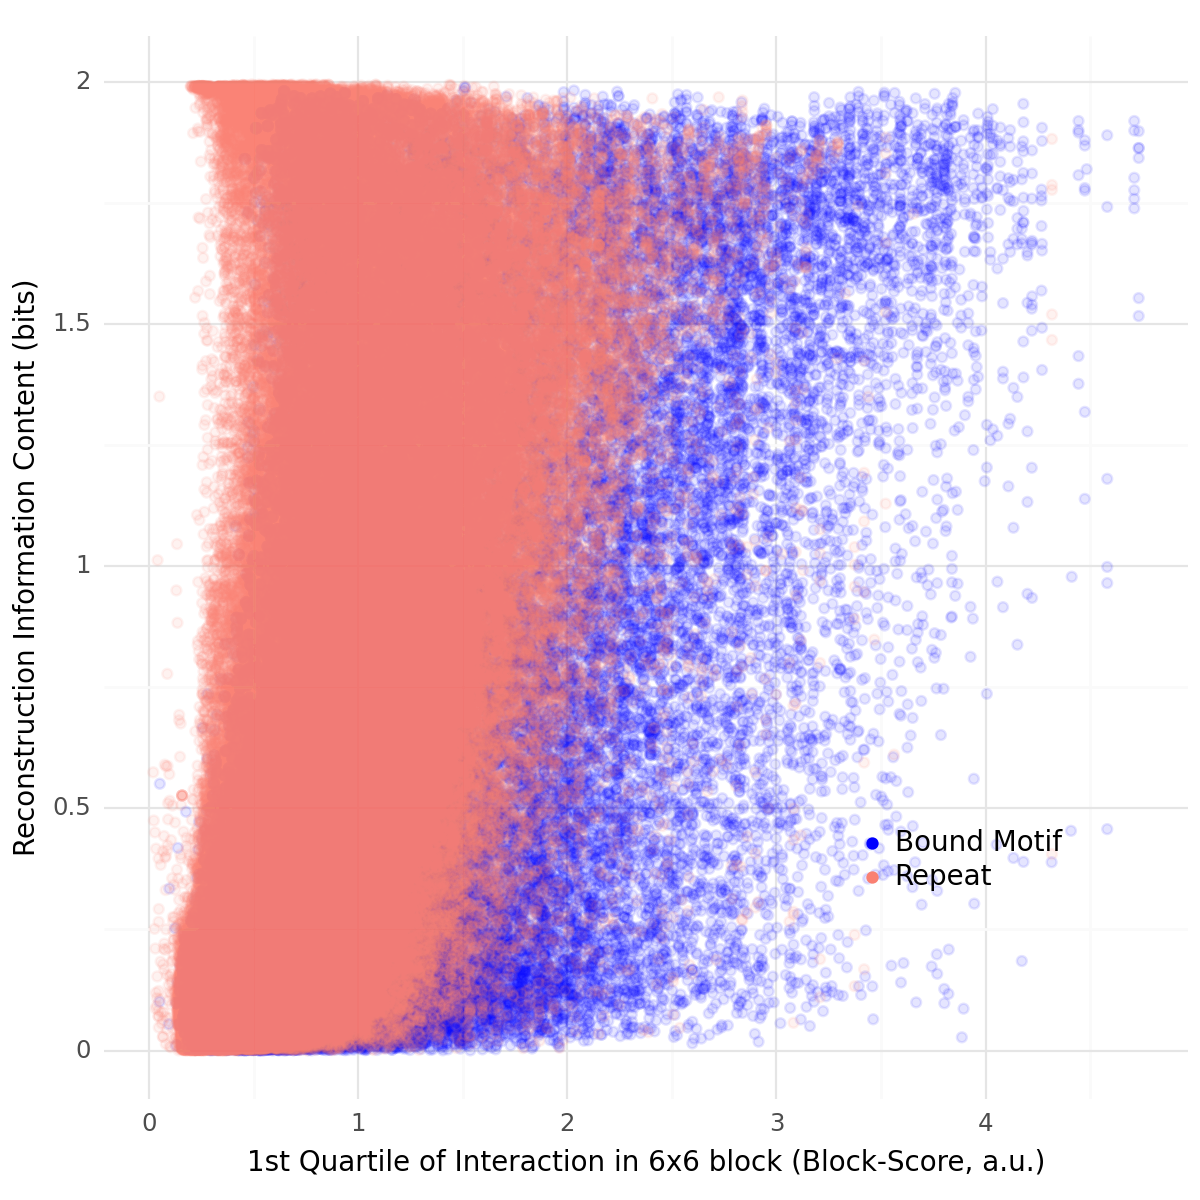

<Figure Size: (600 x 600)>

In [95]:
p = (p9.ggplot(data=all_bp_metrics.query('Type in ["Repeat","Bound Motif"]'), mapping=p9.aes(x="block_quartiles",y="ic", color="Type")) 
 + p9.geom_point(raster=True, alpha=0.1)
 #+ p9.scale_alpha_manual([0.5,1])
 + p9.scale_color_manual(["blue","salmon"])
 + p9.labs(x="1st Quartile of Interaction in 6x6 block (Block-Score, a.u.)",y="Reconstruction Information Content (bits)", color="")
 #+ p9.scale_alpha(guide=False)
 + p9.guides(color = p9.guide_legend(override_aes = {"alpha":1}))#p9.guide_legend())#guide_legend(override.aes = list(size = 3) ) )
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=10),
        legend_key_size=10,
        legend_background=p9.element_blank(),
        legend_title=p9.element_text(size=10),
        legend_position=(0.8,0.3), 
        legend_direction='vertical',
        axis_title=p9.element_text(size=10),
        figure_size=(6,6)
       )
 #+ p9.facet_wrap('~ Type')
)

p

In [39]:
all_bp_metrics

,Type,block_quartiles,ce,ic,conservation,pwm_pval
0,Bound Motif,0.489626,-1.935431,0.358163,0.271,-0.000061
1,Bound Motif,0.489626,-1.287647,0.052844,0.278,-0.000061
2,Bound Motif,0.505185,-1.347014,0.025535,0.296,-0.000061
3,Bound Motif,0.505185,-1.119936,0.246963,0.301,-0.000061
4,Bound Motif,0.505185,-0.925754,0.224464,0.297,-0.000061
...,...,...,...,...,...,...
3039733,Other,0.265941,-2.004852,0.167337,0.041,-1.000000
3039734,Other,0.265941,-0.919377,0.106245,0.190,-1.000000
3039735,Other,0.251683,-2.198679,0.203047,0.441,-1.000000
3039736,Other,0.235129,-0.853995,0.145291,0.534,-1.000000


In [40]:
from plotnine import *

In [41]:
all_bp_metrics.Type.unique()

array(['Bound Motif', 'Splice Site', 'Repeat', 'CDS', 'Other'],
      dtype=object)

In [142]:
cowplot_theme = lambda figure_size, font_size: theme(
    # Set the background to white and remove panel border
    panel_background=element_blank(),
    panel_border=element_blank(),

    # Light grey grid lines
    panel_grid_major=element_line(color='lightgrey', size=0.5),
    panel_grid_minor=element_blank(),

    # Minimize axis ticks
    axis_ticks=element_blank(),

    # Simple font
    text=element_text(color='black'),
    axis_text=element_text(size=font_size),
    axis_title_y=element_text(size=font_size),
    axis_title_x=element_text(size=font_size),
    figure_size = figure_size
    
    
)

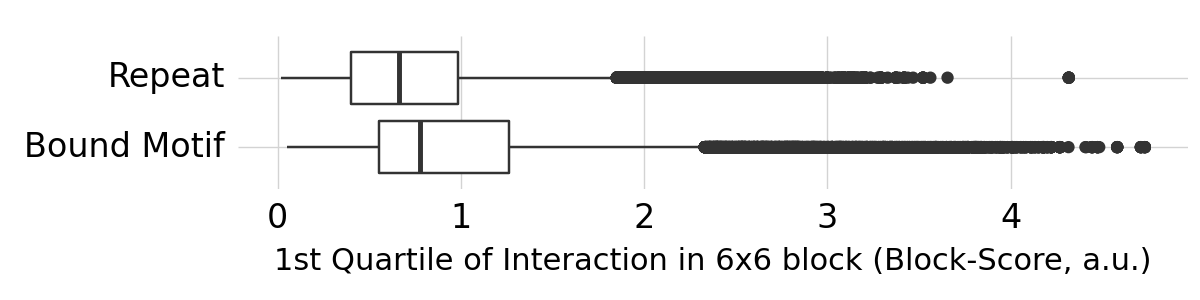

<Figure Size: (600 x 150)>

In [73]:
(ggplot(all_bp_metrics[all_bp_metrics.Type.isin(['Bound Motif', 'Repeat'])], aes('Type', 'block_quartiles'))
    + geom_boxplot() + cowplot_theme(figure_size=(6,1.5), font_size=12)
    + coord_flip()
    + labs(y='1st Quartile of Interaction in 6x6 block (Block-Score, a.u.)', x=''))

In [52]:
from scipy.stats import ranksums

In [54]:
ranksums(all_bp_metrics[all_bp_metrics.Type=='Bound Motif'].block_quartiles.values,
         all_bp_metrics[all_bp_metrics.Type=='Repeat'].block_quartiles.values)

RanksumsResult(statistic=108.21014984257113, pvalue=0.0)

/scratch/tmp/tomazdas/ipykernel_258372/1482875889.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


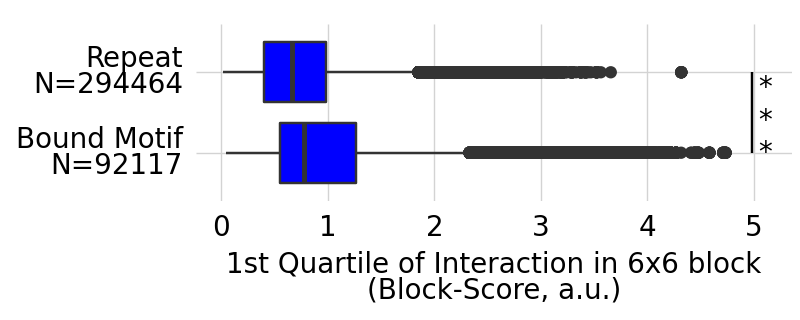

<Figure Size: (400 x 160)>

In [169]:
filtered_data = all_bp_metrics[all_bp_metrics.Type.isin(['Bound Motif', 'Repeat'])]

type_counts = filtered_data['Type'].value_counts().to_dict()

#perform Wilcoxon rank-sum test between the two categories
group1 = filtered_data[filtered_data.Type.str.contains('Bound Motif')]['block_quartiles']
group2 = filtered_data[filtered_data.Type.str.contains('Repeat')]['block_quartiles']
rank_stat, p_value = ranksums(group1, group2)


def get_significance_label(p):
    if p < 0.0001:
        return '*\n*\n*'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'

significance = get_significance_label(p_value)

#add N= labels to Type
filtered_data['Type'] = filtered_data['Type'].apply(lambda x: f"{x}\nN={type_counts[x]}")

p = (ggplot(filtered_data, aes('Type', 'block_quartiles'))
        + geom_boxplot(fill='blue')
        + coord_flip()
        + cowplot_theme(figure_size=(4,1.6), font_size=10)
        + labs(y='1st Quartile of Interaction in 6x6 block\n(Block-Score, a.u.)', x='')
        + annotate('text', x=1.4, y=max(filtered_data['block_quartiles']) + 0.37, label=significance, ha='center', va='center', size=10)
        + annotate('segment', x=1, xend=2, y=max(filtered_data['block_quartiles']) + 0.25, yend=max(filtered_data['block_quartiles']) + 0.25, color='black', size=0.5))

p

In [170]:
ggsave(p, 'fig2_block_score_motif_repeat.png', dpi=500)

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 1.6 in image.
/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig2_block_score_motif_repeat.png


/scratch/tmp/tomazdas/ipykernel_258372/80291055.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


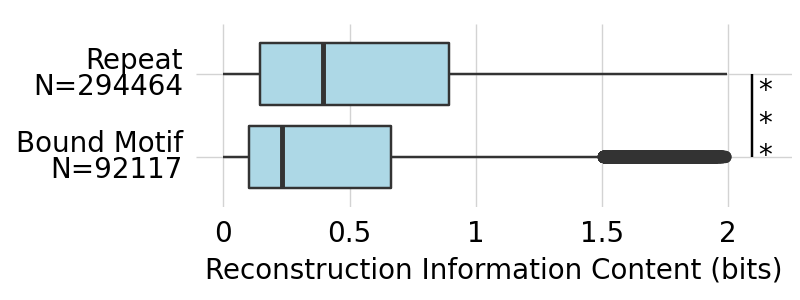

<Figure Size: (400 x 150)>

In [163]:
filtered_data = all_bp_metrics[all_bp_metrics.Type.isin(['Bound Motif', 'Repeat'])]

type_counts = filtered_data['Type'].value_counts().to_dict()

#perform Wilcoxon rank-sum test between the two categories
group1 = filtered_data[filtered_data.Type.str.contains('Bound Motif')]['ic']
group2 = filtered_data[filtered_data.Type.str.contains('Repeat')]['ic']
rank_stat, p_value = ranksums(group1, group2)


def get_significance_label(p):
    if p < 0.0001:
        return '*\n*\n*'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'

significance = get_significance_label(p_value)

#add N= labels to Type
filtered_data['Type'] = filtered_data['Type'].apply(lambda x: f"{x}\nN={type_counts[x]}")

p = (ggplot(filtered_data, aes('Type', 'ic'))
        + geom_boxplot(fill='lightblue')
        + coord_flip()
        + cowplot_theme(figure_size=(4,1.5), font_size=10)
        + labs(y='Reconstruction Information Content (bits)', x='')
        + annotate('text', x=1.4, y=max(filtered_data['ic']) + 0.15, label=significance, ha='center', va='center', size=10)
        + annotate('segment', x=1, xend=2, y=max(filtered_data['ic']) + 0.1, yend=max(filtered_data['ic']) + 0.1, color='black', size=0.5))

p

In [164]:
ggsave(p, 'fig2_rec_motif_repeat.png', dpi=500)

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 1.5 in image.
/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig2_rec_motif_repeat.png


In [ ]:
"Reconstruction Information Content (bits)"

In [115]:
cowplot_theme = lambda figure_size, font_size: theme(
    # Set the background to white and remove panel border
    panel_background=element_blank(),
    panel_border=element_blank(),

    # Light grey grid lines
    panel_grid_major=element_line(color='lightgrey', size=0.5),
    panel_grid_minor=element_blank(),

    # Minimize axis ticks
    axis_ticks=element_blank(),

    # Simple font
    text=element_text(color='black'),
    axis_text=element_text(size=font_size),
    axis_title_y=element_text(size=font_size),
    axis_text_x=element_text(angle=35, hjust=1),
    figure_size = figure_size
    
    
)

/scratch/tmp/tomazdas/ipykernel_258372/447481109.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


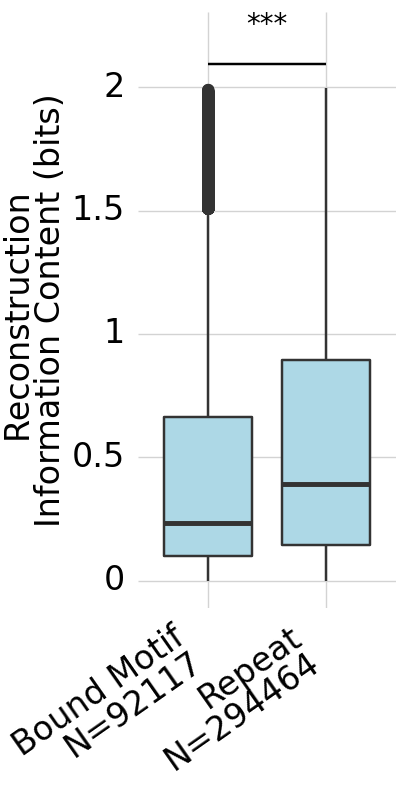

<Figure Size: (200 x 400)>

In [116]:
filtered_data = all_bp_metrics[all_bp_metrics.Type.isin(['Bound Motif', 'Repeat'])]

# Calculate counts for each Type
type_counts = filtered_data['Type'].value_counts().to_dict()

# Perform Wilcoxon rank-sum test between the two categories
group1 = filtered_data[filtered_data.Type.str.contains('Bound Motif')]['ic']
group2 = filtered_data[filtered_data.Type.str.contains('Repeat')]['ic']
rank_stat, p_value = ranksums(group1, group2)

# Mapping p-values to significance indicators
def get_significance_label(p):
    if p < 0.0001:
        return '***'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'

significance = get_significance_label(p_value)

# Add N= labels to Type
filtered_data['Type'] = filtered_data['Type'].apply(lambda x: f"{x}\nN={type_counts[x]}")

# Get the maximum value for y position adjustment
y_max = filtered_data['ic'].max()

# Create the plot
p = (ggplot(filtered_data, aes('Type', 'ic'))
        + geom_boxplot(fill="lightblue")
        + cowplot_theme(figure_size=(2,4), font_size=12)
        + labs(x='', y="        Reconstruction\nInformation Content (bits)")
        + annotate('text', x=1.5, y=y_max + 0.2, label=significance, ha='center', va='bottom', size=10)
        + annotate('segment', x=1, xend=2, y=y_max + 0.1, yend=y_max + 0.1, color='black', size=0.5))

# Display the plot
p

In [117]:
ggsave(p, 'fig2_new_box_rec_motif_repeat.png', dpi=500)

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 2 x 4 in image.
/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig2_new_box_rec_motif_repeat.png


/scratch/tmp/tomazdas/ipykernel_258372/137122089.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


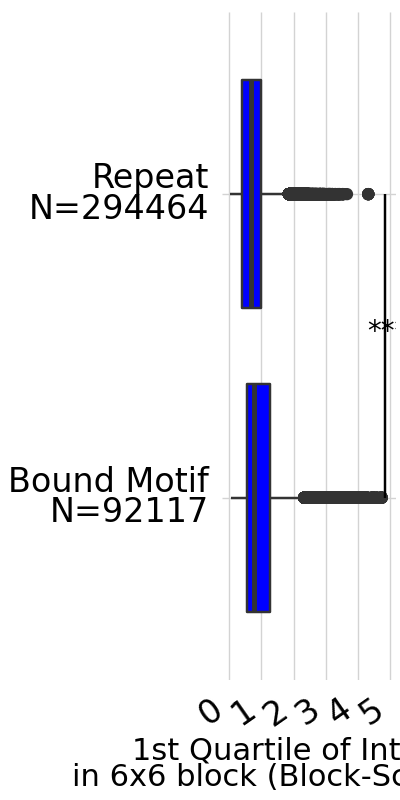

<Figure Size: (200 x 400)>

In [122]:
filtered_data = all_bp_metrics[all_bp_metrics.Type.isin(['Bound Motif', 'Repeat'])]

# Calculate counts for each Type
type_counts = filtered_data['Type'].value_counts().to_dict()

# Perform Wilcoxon rank-sum test between the two categories
group1 = filtered_data[filtered_data.Type.str.contains('Bound Motif')]['block_quartiles']
group2 = filtered_data[filtered_data.Type.str.contains('Repeat')]['block_quartiles']
rank_stat, p_value = ranksums(group1, group2)

# Mapping p-values to significance indicators
def get_significance_label(p):
    if p < 0.0001:
        return '***'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'

significance = get_significance_label(p_value)

# Add N= labels to Type
filtered_data['Type'] = filtered_data['Type'].apply(lambda x: f"{x}\nN={type_counts[x]}")

# Get the maximum value for y position adjustment
y_max = filtered_data['block_quartiles'].max()

# Create the plot
p = (ggplot(filtered_data, aes('Type', 'block_quartiles'))
        + geom_boxplot(fill="blue")
        + cowplot_theme(figure_size=(2,4), font_size=12)
        + labs(x='', y='    1st Quartile of Interaction\nin 6x6 block (Block-Score, a.u.)')
        + annotate('text', x=1.5, y=y_max + 0.2, label=significance, ha='center', va='bottom', size=10)
        + annotate('segment', x=1, xend=2, y=y_max + 0.1, yend=y_max + 0.1, color='black', size=0.5)
        + coord_flip())

# Display the plot
p

In [106]:
ggsave(p, 'fig2_new_box_block_motif_repeat.png', dpi=500)

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 2 x 6 in image.
/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig2_new_box_block_motif_repeat.png


In [49]:
pred_types = {"conservation":"Conservation",
              "ic":"Information Content", # Reconstruction (IC)
              "ce":"Reconstruction", # Reconstruction (CE)
              "block_quartiles":"Block-Score",
              #"block_medians":"6x6 Block Median Interaction",
              "pwm_pval":"PWM P-value",
             }

In [50]:
roc_plot_df_list = []
roc_auc_dict = {}
bp_metrics_filtered = all_bp_metrics.copy()#.query('Type != "Splice Site"')
labels = bp_metrics_filtered["Type"].isin(["Bound Motif"]) #"Splice Site"#"Bound Motif"

for pred_type in pred_types:
    fpr, tpr, thresholds = roc_curve(y_true=np.array(labels), y_score=np.array(bp_metrics_filtered[pred_type]))
    roc_auc = roc_auc_score(y_true=np.array(labels), y_score=np.array(bp_metrics_filtered[pred_type]))
    roc_auc_dict[pred_types[pred_type]] = roc_auc
    roc_plot_df_list.append(pd.DataFrame({"fpr":fpr,"tpr":tpr,"roc_auc":roc_auc,"Type":pred_types[pred_type]}))
roc_plot_df = pd.concat(roc_plot_df_list)

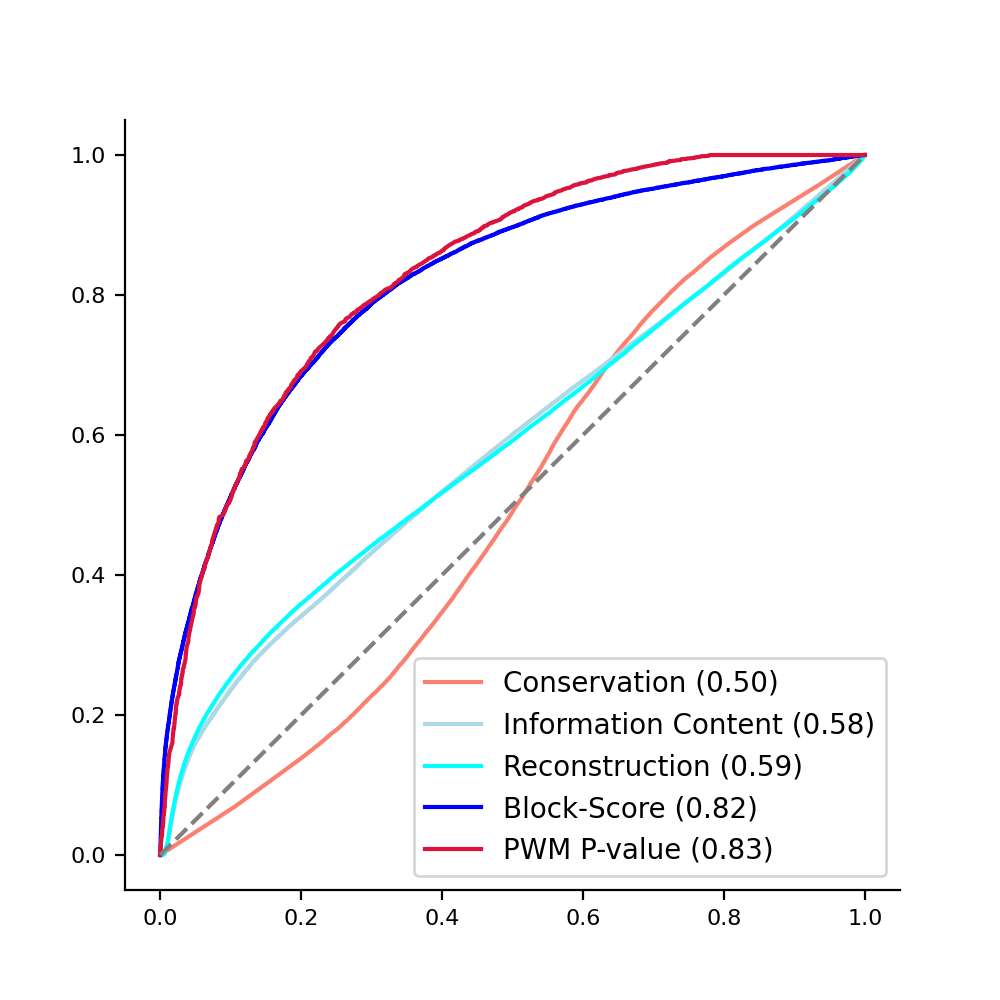

In [51]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
colors = ["salmon","lightblue","cyan","blue","crimson"]#["steelblue","lightblue","darkgreen","blue","crimson","yellow"]#["yellow","purple","green","black","blue","pink"]

for i,pred_type in enumerate(pred_types.values()):
    roc_plot_df_sub = roc_plot_df.query('Type == @pred_type')
    ax.plot(roc_plot_df_sub["fpr"],roc_plot_df_sub["tpr"], color=colors[i], label="{} ({:2.2f})".format(pred_type,roc_plot_df_sub["roc_auc"].iloc[0]))
    #ax.plot(roc_dict[model]["rec"],roc_dict[model]["prec"], color=color, label="AUPRC = {:2.2f} {}".format(roc_dict[model]["auprc"], model))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=8)
#ax.tick_params(axis='both', which='minor', labelsize=8)

plt.show()